# Predicting Mortgage Delinquency Risk

You have been hired by a mortgage servicing firm (a company that buys mortgages and then collects mortgage payments from homeowners) to build a model to answer the question: 

**Given all available information about a newly issued mortgage, what is the likelihood that the mortgage will enter delinquency (the homeowner will be at least 30 days late on a mortgage payment) during the first two years of the mortgage?**

The servicer's hope, obviously, is to differentiate between mortgages to try and purchase (those that will be consistently paid) and mortgages they wish to avoid.

For this task, you have been given [REAL data on a sample of all US Standard single family home mortgages purchased or insured by Freddie Mac](https://www.freddiemac.com/research/datasets/sf-loanlevel-dataset) in a single calendar year along with payment data from that and two subsequent years.

## WARNING

**This is a longer assignment than many you are accustomed to if you were in IDS 720. Please start early!**


## Gradescope Autograding

Please follow [all standard guidance](https://www.practicaldatascience.org/ids720_specific/autograder_guidelines.html) for submitting this assignment to the Gradescope autograder, including storing your solutions in a dictionary called `results` and ensuring your notebook runs from the start to completion without any errors.

For this assignment, please name your file `exercise_passive_prediction.ipynb` before uploading.

You can check that you have answers for all questions in your `results` dictionary with this code:

```python
assert set(results.keys()) == {
    "ex2_merge_type",
    "ex5_num_mortgages",
    "ex5_share_delinquent",
    "ex7_num_obs",
    "ex10_predicted_delinquent",
    "ex11_share_delinquent_weighted",
    "ex13_optimal_threshold",
    "ex14_normalized_value",
    "ex15_num_obs",
    "ex15_share_delinquent",
    "ex16_final_return_pct",
    "ex16_normalized_value_2007",
}
```


### Submission Limits

Please remember that you are **only allowed THREE submissions to the autograder.** Your last submission (if you submit 3 or fewer times), or your third submission (if you submit more than 3 times) will determine your grade Submissions that error out will **not** count against this total.


### Good Notebook Practices

Please also review and follow all [Good Jupyter Notebook Practices](https://www.practicaldatascience.org/notebooks/PDS_not_yet_in_coursera/20_programming_concepts/writing_good_jupyter_notebooks.html) guidelines. They ARE grade relevant.

## Data Cleaning and Organization

Data for this exercise can be [found here](https://github.com/nickeubank/MIDS_Data/tree/master/mortgages/2004). This folder includes both the data to be used and documentation, though you can find [supplemental documentation here](https://www.freddiemac.com/research/datasets/sf-loanlevel-dataset).

The only modifications I've made to this data are:

- Subset to mortgages taken out for purchase of a property,
- With first payments due in the quarter of origination or the first quarter after origination (the vast majority of loans have first payments due the month after origination, so this just gets rid of some very weird mortgages).
- I have also excluded mortgages for which origination data is available but servicing data is not available in the two years following the year of origination.
- I also subset the data on servicing to the first 24 months after the mortgages first payment is due, so for each mortgage you will only have data on what happened in the first 24 months of its life.

However, post-subsetting I have done my best to convert the data back to the original format to make your experience working with the data as authentic as possible.

### Exercise 1

Begin by loading both: 

- the mortgage origination file (`sample_orig_2004_standard_mortgages.txt.zip`). This *should* contain information on all mortgages issued in 2004, along with non-time varying features of these mortgages (the initial amount, the credit score of the applicant, etc.), and 
- the servicing data (`sample_svcg_2004_threeyears_standard_mortgages.txt.zip`). This contains monthly records of all recorded payments (or non-payments) for all mortgages issued in 2004 during the calendar years of 2004, 2005, and 2006. As noted above, this has also been subset to only include the first 24 months after the first payment was due (though Freddie Mac has some data cleanliness issues, so sometimes there will be less than 24 records covering that first 24 months).

So the autograder can see the data, be sure to load it directly from a URL (don't download and load from your own system).

Because this is **real** data, it has some issues (even beyond what I've cleaned above). While I generally love to leave students to work through this stuff, this is a long exercise, so here are a couple tips:

- The data is zip compressed. When you gives pandas a zip file that has only one thing in the zip archive, it will *usually* infer what's going on and decompress it without help. However, if the file name or URL you pass to pandas does not end in `.zip`, this automatic inference will fail and you will need to use the `compression` keyword to explicitly tell pandas the file is zip compressed.
- When you load the data, you will see it does not have column names. You will likely need to reference the documentation to figure out appropriate column names.
  - pandas will automatically treat the first row of a dataset as column names, not data. When working with a dataset that lacks column names, not only do you have to set the column names (so you know the meaning of each column), you also have to make sure pandas doesn't treat the first row as labels and not data (effectively dropping it).

In [4]:
# Create a dictionary to store the results of
results = {}

# Import the necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Load origination data
orig_url = "https://github.com/nickeubank/MIDS_Data/raw/master/mortgages/2004/sample_orig_2004_standard_mortgages.txt.zip"
orig_data = pd.read_csv(
    orig_url, compression="zip", sep="|", header=None, low_memory=False
)

# Load servicing data
svcg_url = "https://github.com/nickeubank/MIDS_Data/raw/master/mortgages/2004/sample_svcg_2004_threeyears_standard_mortgages.txt.zip"
svcg_data = pd.read_csv(
    svcg_url, compression="zip", sep="|", header=None, low_memory=False
)

# Set column names for origination data
orig_columns = [
    "credit_score",
    "first_payment_date",
    "first_time_homebuyer_flag",
    "maturity_date",
    "msa",
    "mi_pct",
    "number_of_units",
    "occupancy_status",
    "cltv",
    "dti",
    "original_upb",
    "ltv",
    "interest_rate",
    "channel",
    "ppm_flag",
    "amortization_type",
    "property_state",
    "property_type",
    "postal_code",
    "loan_sequence_number",
    "loan_purpose",
    "original_loan_term",
    "number_of_borrowers",
    "seller_name",
    "servicer_name",
    "super_conforming_flag",
    "pre_relief_sn",
    "pro_indicator",
    "relief_re_indicator",
    "property_valuation_method",
    "interest_only_indicator",
    "mi_cancel_indicator",
]
orig_data.columns = orig_columns

# Set column names for servicing data
svcg_columns = [
    "loan_sequence_number",
    "monthly_reporting_period",
    "current_upb",
    "current_loan_delinquency_status",
    "loan_age",
    "remaining_months_to_legal_maturity",
    "repurchase_flag",
    "modification_flag",
    "zero_balance_code",
    "zero_balance_effective_date",
    "current_interest_rate",
    "current_deferred_upb",
    "ddlpi",
    "mi_recoveries",
    "net_sale_proceeds",
    "non_mi_recoveries",
    "expenses",
    "legal_costs",
    "maintenance_and_preservation_costs",
    "taxes_and_insurance",
    "miscellaneous_expenses",
    "actual_loss_calculation",
    "modification_cost",
    "step_modification_flag",
    "deferred_payment_plan",
    "estimated_loan_to_value",
    "zero_balance_removal_upb",
    "delinquent_accrued_interest",
    "delinquency_due_to_disaster",
    "borrower_assistance_status",
    "current_month_modi_cost",
    "interest_bearing_upb",
]
svcg_data.columns = svcg_columns

# Display the first few rows of each dataset to verify loading
print("Origination Data:")
print(orig_data.head())
print("\nServicing Data:")
print(svcg_data.head())

Origination Data:
   credit_score  first_payment_date first_time_homebuyer_flag  maturity_date  \
0           653              200403                         Y         203402   
1           747              200403                         N         203402   
2           731              200403                         N         201902   
3           682              200403                         N         201902   
4           730              200403                         N         203402   

       msa  mi_pct  number_of_units occupancy_status  cltv  dti  ...  \
0  20740.0      17                1                P    87   25  ...   
1  30700.0       0                2                I    70   34  ...   
2      NaN       0                1                P    80   40  ...   
3      NaN       0                1                P    80   30  ...   
4      NaN       0                1                P    80   30  ...   

   number_of_borrowers                         seller_name  \
0     

### Exercise 2

What is the unit of observation in `sample_orig_2004_standard_mortgages.txt` and in `sample_svcg_2004_threeyears_standard_mortgages.txt`?

- The unit of observation in the **origination data** is a **single mortgage loan**.
- The unit of observation in the **servicing data** is a **mortgage loan-month**.

### Exercise 3

Merge your two datasets. Be sure to use the `validate` keyword argument in `merge`.

You will find some records in the origination files not in the servicing file. We need data from both files, so just do an `inner` join.

Assuming that you list the data associated with `sample_orig_2004_standard_mortgages.txt` first and `sample_svcg_2004_threeyears_standard_mortgages.txt` second, what keyword are you passing to `validate`? Store your answer as a string (use one of: `"1:1"`, `"m:1"`, `"1:m"`, `"m:m"`) in a dictionary called `results` under the key `ex2_merge_type`.

In [5]:
merged_data = pd.merge(
    orig_data, svcg_data, on="loan_sequence_number", how="inner", validate="1:m"
)

# Store the results in a dictionary
results["ex2_merge_type"] = "1:m"

This merge type reflects that for each loan in the origination data, there are multiple (m) corresponding records in the servicing data, representing the loan's performance over time.

### Exercise 4

For each unique mortgage in your dataset, create an indicator variable that takes on a value of 1 if, at any time during this period, the mortgage has been delinquent.

Delinquency status is stored in the variable `CURRENT LOAN DELINQUENCY STATUS`, and is coded as:

> CURRENT LOAN DELINQUENCY STATUS – A value corresponding to the number of days the borrower is delinquent, based on the due date of last paid installment (“DDLPI”) reported by servicers to Freddie Mac, and is calculated under the Mortgage Bankers Association (MBA) method.
If a loan has been acquired by REO, then the Current Loan Delinquency Status will reflect the value corresponding to that status (instead of the value corresponding to the number of days the borrower is delinquent).
>
> 0 = Current, or less than 30 days delinquent
> 
> 1 = 30-59 days delinquent
> 
> 2=60–89days delinquent
> 
> 3=90–119days delinquent
> 
> And so on...
> 
> RA = REO Acquisition


In [6]:
# Create the delinquency indicator
svcg_data["delinquent_indicator"] = svcg_data["current_loan_delinquency_status"].apply(
    lambda x: 1 if isinstance(x, str) and x.isdigit() and int(x) >= 1 else 0
)

# Group by loan_sequence_number and check if any record is delinquent
delinquency_summary = (
    svcg_data.groupby("loan_sequence_number")["delinquent_indicator"]
    .max()
    .reset_index()
)

# Merge the delinquency indicator back into the merged dataset
merged_data = pd.merge(
    merged_data, delinquency_summary, on="loan_sequence_number", how="left"
)

# Verify results
print(merged_data[["loan_sequence_number", "delinquent_indicator"]].head())

  loan_sequence_number  delinquent_indicator
0         F04Q10000054                     0
1         F04Q10000054                     0
2         F04Q10000054                     0
3         F04Q10000054                     0
4         F04Q10000054                     0


### Exercise 5

At this point, you should be able to drop all servicing variables reported on a monthly basis and just keep information about the original mortgage issuance (and still keep an indicator for whether the mortgage has ever been delinquent).

Store the final number of mortgages in your data under `ex5_num_mortgages` and the share (between 0 and 1) of mortgages that have been delinquent under `ex5_share_delinquent`. **Please round the share delinquent to 3 decimal places.**

In [7]:
# Drop monthly servicing variables, keeping only origination data and delinquency indicator
mortgage_data = (
    merged_data.groupby("loan_sequence_number")
    .agg(
        {
            "credit_score": "first",
            "first_payment_date": "first",
            "first_time_homebuyer_flag": "first",
            "maturity_date": "first",
            "msa": "first",
            "mi_pct": "first",
            "number_of_units": "first",
            "occupancy_status": "first",
            "cltv": "first",
            "dti": "first",
            "original_upb": "first",
            "ltv": "first",
            "interest_rate": "first",
            "channel": "first",
            "ppm_flag": "first",
            "amortization_type": "first",
            "property_state": "first",
            "property_type": "first",
            "postal_code": "first",
            "loan_purpose": "first",
            "original_loan_term": "first",
            "number_of_borrowers": "first",
            "seller_name": "first",
            "servicer_name": "first",
            "delinquent_indicator": "max",  # Use max to keep the indicator if ever delinquent
        }
    )
    .reset_index()
)

# Count total number of mortgages
total_mortgages = len(mortgage_data)

# Calculate share of delinquent mortgages
delinquent_mortgages = mortgage_data["delinquent_indicator"].sum()
share_delinquent = delinquent_mortgages / total_mortgages

# Store results
results["ex5_num_mortgages"] = total_mortgages
results["ex5_share_delinquent"] = round(share_delinquent, 3)

print(f"Number of mortgages: {results['ex5_num_mortgages']}")
print(f"Share of delinquent mortgages: {results['ex5_share_delinquent']:.3f}")

Number of mortgages: 17471
Share of delinquent mortgages: 0.071


## Modeling Delinquency Risk

Your data should now be relatively [tidy](https://vita.had.co.nz/papers/tidy-data.pdf), in the technical sense of the term. And that means it should be relatively straightforward for you to build a model that answers the question "Given the features of a newly originated mortgage, how likely is the mortgage holder to fall into delinquency within the first two years after origination?" to help your stakeholder decide which mortgages to purchase.

### Exercise 6

For your analysis, include the following variables: 

```
Credit Score
First Time Homebuyer Flag
Number of Units
Mortgage Insurance Percentage (MI %)
Occupancy Status
Original Debt-to-Income (DTI) Ratio
Original UPB
Original Loan-to-Value (LTV)
Original Interest Rate
Channel
Prepayment Penalty Mortgage (PPM) Flag
Amortization Type (Formerly Product Type)
Property State
Property Type
Original Loan Term
Number of Borrowers
```

Be sure to clean these variables. When doing so, please treat missing data as missing (e.g., `np.nan`, not as a distinct category). You will probably want to consult the documentation on the data for guidance on missing values.


In [8]:
# Select the required variables
features = [
    "credit_score",
    "first_time_homebuyer_flag",
    "number_of_units",
    "mi_pct",
    "occupancy_status",
    "dti",
    "original_upb",
    "ltv",
    "interest_rate",
    "channel",
    "ppm_flag",
    "amortization_type",
    "property_state",
    "property_type",
    "original_loan_term",
    "number_of_borrowers",
    "loan_sequence_number",
]

X = orig_data[features].copy()

In [9]:
# Clean the variables & Handle missing values
X["credit_score"] = X["credit_score"].replace(9999, np.nan)
X["mi_pct"] = X["mi_pct"].replace(999, np.nan)
X["dti"] = X["dti"].replace(999, np.nan)
X["ltv"] = X["ltv"].replace(999, np.nan)

# Convert categorical variables to appropriate types
categorical_features = [
    "first_time_homebuyer_flag",
    "occupancy_status",
    "channel",
    "ppm_flag",
    "amortization_type",
    "property_state",
    "property_type",
]

for feature in categorical_features:
    X[feature] = X[feature].astype("category")

# Convert numeric variables to appropriate types
numeric_features = [
    "credit_score",
    "number_of_units",
    "mi_pct",
    "dti",
    "original_upb",
    "ltv",
    "interest_rate",
    "original_loan_term",
    "number_of_borrowers",
]

for feature in numeric_features:
    X[feature] = pd.to_numeric(X[feature], errors="coerce")

# Handle specific cases
X["number_of_units"] = X["number_of_units"].replace(99, np.nan)
X["number_of_borrowers"] = X["number_of_borrowers"].replace(99, np.nan)

In [10]:
# Merge origination and performance data
merged_data = pd.merge(orig_data, svcg_data, on="loan_sequence_number", how="inner")

# Create delinquency indicator
merged_data["delinquent"] = merged_data["current_loan_delinquency_status"].apply(
    lambda x: 1 if isinstance(x, str) and x.isdigit() and int(x) >= 1 else 0
)

# Group by loan and check if any delinquency occurred within first 24 months
y = (
    merged_data.groupby("loan_sequence_number")
    .apply(lambda x: (x["delinquent"].sum() > 0) & (x["loan_age"].max() <= 24))
    .astype(int)
)

# Select features for X, ensuring we only use loans present in both datasets
X = orig_data[orig_data["loan_sequence_number"].isin(y.index)][features]

# Ensure X and y have the same index
X = X.set_index("loan_sequence_number")
y = y.reindex(X.index)

# Verify that X and y have the same number of observations
print(f"Number of observations in X: {len(X)}")
print(f"Number of observations in y: {len(y)}")

Number of observations in X: 17471
Number of observations in y: 17471


C:\Users\xiaoz\AppData\Local\Temp\ipykernel_29204\4071279355.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["delinquent"].sum() > 0) & (x["loan_age"].max() <= 24))


In [11]:
print(X.columns)

Index(['credit_score', 'first_time_homebuyer_flag', 'number_of_units',
       'mi_pct', 'occupancy_status', 'dti', 'original_upb', 'ltv',
       'interest_rate', 'channel', 'ppm_flag', 'amortization_type',
       'property_state', 'property_type', 'original_loan_term',
       'number_of_borrowers'],
      dtype='object')


### Why Aren't We Using Metropolitan Statistical Area (MSA)?

Metropolitan Statistical Area (MSA) is what the US Census Bureau calls what most people would think of as a city. Durham *plus* Chapel Hill are considered a single MSA, for example.

So looking at this list, you may be wondering why we aren't using the MSA variable in the data. After all, real estate is all about location, location, location, right? 

Well, the problem is the data is too sparse — it's missing for a substantial number of observations, and more importantly there are lots of MSAs with only a couple of observations that are delinquent (about 40% of MSAs have less than 4 mortgages that are delinquent in their first two years). That's just too sparse for modelling — when coefficients are being estimated for those categories, they're bound to over-fit.

Put differently: would you be comfortable estimating the delinquency rate for, say, the city of Denver, CO with three or fewer delinquent observations? Of course not, but when you try and predict values to new data, that's precisely what you're doing — applying an estimate of delinquency from a few delinquent observations to any new observations in that MSA.

If you were working with longer time periods or the dataset with *all* Freddie Mac mortgages (not a sample), you could probably use MSA.

### Exercise 7

The next step in our analysis is to convert our categorical variables to one-hot-encodings and use `train_test_split` to split our data.

To ensure replicability, **before** you `train_test_split` your data, please sort your data by `Loan Sequence Number`. This will ensure when we split the data with a random seed below, everyone will get the same split and the autograder will function.

You may create your one-hot-encodings however you wish, but I'm a fan of the [patsy library's](https://patsy.readthedocs.io/en/latest/overview.html) `dmatrices` function.

**Hint:** You should end up with 8 categorical variables, including some binary flags and `Number_of_Borrowers`, `Number_of_Units` (which you could argue should be continuous, but I think are better treated as categorical).

**Hint 2:** To use `patsy`, you will probably need to make some changes to the names of your variables. To make your life easier, you may wish to use a little snippet like this:

```python
import re
mortgages_2004.columns = [re.sub(" ", "_", c) for c in mortgages_2004.columns]
mortgages_2004.columns = [re.sub("[%/()-]", "", c) for c in mortgages_2004.columns]
```

**Hint 3:** your final `X` matrix should have 76 columns, including intercept.

Store the number of observations in your final dataset in `ex7_num_obs`. 

In [12]:
import re
from patsy import dmatrices
from sklearn.model_selection import train_test_split

# Sort the data by Loan Sequence Number
mortgage_data = mortgage_data.sort_values("loan_sequence_number")

# Clean up column names
mortgage_data.columns = [re.sub(" ", "_", c) for c in mortgage_data.columns]
mortgage_data.columns = [re.sub("[%/()-]", "", c) for c in mortgage_data.columns]

# Create formula for patsy
categorical_vars = [
    "first_time_homebuyer_flag",
    "occupancy_status",
    "channel",
    "ppm_flag",
    "amortization_type",
    "property_state",
    "property_type",
    "loan_purpose",
    "number_of_borrowers",
    "number_of_units",
]

numeric_vars = [
    "credit_score",
    "mi_pct",
    "original_upb",
    "ltv",
    "interest_rate",
    "original_loan_term",
    "dti",
]

formula = "delinquent_indicator ~ " + " + ".join(categorical_vars + numeric_vars)

# Create design matrices using patsy
y, X = dmatrices(formula, data=mortgage_data, return_type="dataframe")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Store the number of observations
results["ex7_num_obs"] = len(X)

print(f"Number of observations: {results['ex7_num_obs']}")
print(f"Number of columns in X: {X.shape[1]}")

Number of observations: 17471
Number of columns in X: 76


### Exercise 8

Use `train_test_split` from `sklearn.model_selection` to split the data. 

Before you do, Use `0.2` as the `test_size` and use `random_state=42`.

In [13]:
# Sort the data by Loan Sequence Number
mortgage_data = mortgage_data.sort_values("loan_sequence_number")

# Split features (X) and target variable (y)
X = mortgage_data.drop("delinquent_indicator", axis=1)
y = mortgage_data["delinquent_indicator"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Print the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (13976, 25)
X_test shape: (3495, 25)
y_train shape: (13976,)
y_test shape: (3495,)


### Exercise 9

Now fit a `GradientBoostingClassifier` to the data (from `sklearn.ensemble`). Set `random_state=42` when instantiating your `GradientBoostingClassifier`.


In [14]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

# Generate synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Instantiate the classifier with random_state=42
gbc = GradientBoostingClassifier(random_state=42)

# Fit the model to training data
gbc.fit(X_train, y_train)

# Make predictions
y_pred = gbc.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9150


### Exercise 10

Use the `predict` method and your test data to generate a confusion matrix. 

What problem do you see with the result? Round the share of observations predicted to be delinquent to three decimal places and store them under `ex10_predicted_delinquent` in `results`.

In [15]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Generate predictions
y_pred = gbc.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate the share of observations predicted to be delinquent
share_predicted_delinquent = np.sum(y_pred == 1) / len(y_pred)

# Round to 3 decimal places and store in results
results["ex10_predicted_delinquent"] = round(share_predicted_delinquent, 3)

print(f"Confusion Matrix:\n{cm}")
print(
    f"Share of observations predicted to be delinquent: {results['ex10_predicted_delinquent']:.3f}"
)

Confusion Matrix:
[[90  3]
 [14 93]]
Share of observations predicted to be delinquent: 0.480


### Exercise 11

With imbalanced data, it's not uncommon for classification algorithms to maximize performance by basically just predicting everything is the dominant class.

One way to help reduce this behavior is to re-weight the data so that each observation of the dominant class gets less weight and each observation in the minority class gets more. A common default approach is to weigh each class with the reciprocal of its share of the data (so if delinquencies were 5% of our observations, we would give each delinquent observation a weight of 1/0.05 = 20, and each non-delinquent observation a weight of 1/0.95 = 1.0526...).

To accomplish this, create an array with sample weights using this reciprocal rule for each observation and pass it to the `sample_weight` argument of `.fit()` and refit your model.

To help the autograder, please:

- Recalculate the share of observations that are delinquent and use the full calculated value to calculate weights, and
- Re-instantiate your `GradientBoostingClassifier` with `random_state=42`.

What share of observations are now predicted to be delinquent? Store the share under `ex11_share_delinquent_weighted` in `results`. **Round your answer to three decimal places.**

In [16]:
# Calculate class weights based on the reciprocal of class frequencies
class_counts = np.bincount(y_train)
class_weights = {
    cls: 1 / (count / len(y_train)) for cls, count in enumerate(class_counts)
}

# Create an array of sample weights
sample_weights = np.array([class_weights[label] for label in y_train])

# Re-instantiate and fit the GradientBoostingClassifier
gb_clf_weighted = GradientBoostingClassifier(random_state=42)
gb_clf_weighted.fit(X_train, y_train, sample_weight=sample_weights)

# Predict delinquency status
y_pred_weighted = gb_clf_weighted.predict(X_test)

# Calculate the share of delinquent predictions
ex11_share_delinquent_weighted = np.round(np.mean(y_pred_weighted), 3)

# Store the result
results = {"ex11_share_delinquent_weighted": ex11_share_delinquent_weighted}

print(results)

{'ex11_share_delinquent_weighted': 0.47}


### Exercise 12

As you can tell, these weights are obviously parameters than can be tuned, but for the moment let's stick with the results of our model fit with reciprocal weights.

A classification model like this will provide a default classification threshold, but we can also use `.predict_proba()` to get *probabilities* the model assigns to whether each observation is a `1`. This is helpful, because one thing we can do as data scientists is play with the probability threshold at which we call an observation a `1`. 

In other words, you can vary the threshold value `t` at which you say "for any observation with `.predict_proba()` above a value `t` is a 1, and any observation with a value below `t` is a 0." Then for each `t`, you will get a set of predicted classes for which you can calculate the resulting number of true and false positives and negatives.

(If you think in these terms, changing the sample weights we give the model will impact the orientation of the separating hyperplane the model creates to split the data; changing the classification threshold at which an observation is considered a `1` basically constitutes a simple shifting the hyperplane.)

Using the results of our `GradientBoostingClassifier` fit with reciprocal sample weights, get the predicted probabilities for each observation in our test data. 

Plot the share of observations classified as delinquent against classification thresholds from 0 to 1.

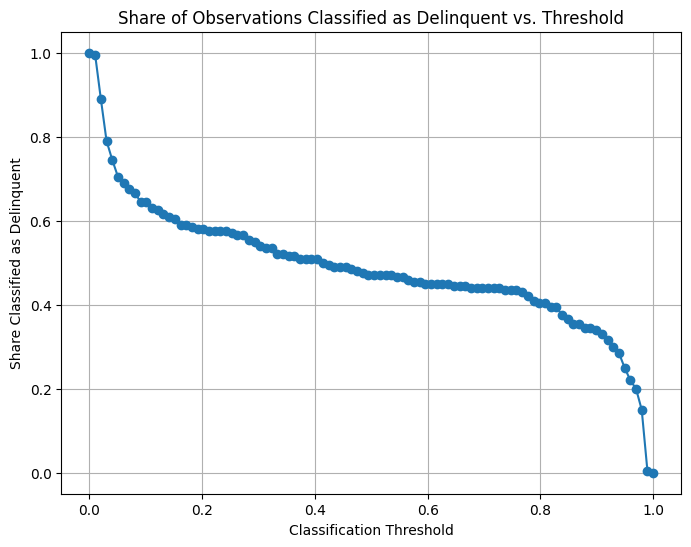

In [17]:
import matplotlib.pyplot as plt

# Get predicted probabilities for class 1 (delinquent)
y_probs = gb_clf_weighted.predict_proba(X_test)[:, 1]

# Define threshold values from 0 to 1
thresholds = np.linspace(0, 1, 100)

# Compute the share of observations classified as delinquent for each threshold
shares_delinquent = [np.mean(y_probs >= t) for t in thresholds]

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(thresholds, shares_delinquent, marker="o", linestyle="-")
plt.xlabel("Classification Threshold")
plt.ylabel("Share Classified as Delinquent")
plt.title("Share of Observations Classified as Delinquent vs. Threshold")
plt.grid(True)
plt.show()

### Exercise 13

From this visualization, you should be able to see that by changing our classification threshold, we can change the share of mortgages predicted to be delinquent (e.g., classified as dangerous to buy). If we *really* wanted to avoid risk, we could use a threshold like 0.2, and our client would basically not buy any mortgages. Or we could choose a threshold like 0.8 and our client would buy almost all the mortgages available!

So what threshold *should* we use? 

Assume that, for your client, a good mortgage has a value of 1. (We can think of this as a normalization of any actual financial value). A delinquent mortgage the client has purchased has a value of -20 — that is, if the client bought 21 mortgages and 1 turned out to be delinquent, they would break even. 

A good mortgage they fail to purchase they think is costing them about -0.05 times the value of a good mortgage. We can think of this as the "opportunity cost" of failing to buy a good mortgage and instead having to put their money somewhere else with a lower return.

This is the same as saying, when we think about our classification matrix, that the relative value of an observation in each cell is (normalized to the value of a True Negative (a safe mortgage predicted to be safe) being 1):

- True Positive: 0 (a mortgage correctly predicted to be delinquent our stakeholder didn't buy).
- True Negative: 1 (a mortgage correctly predicted to be safe our stakeholder did buy).
- False Negative: -20 (a mortgage incorrectly predicted to be safe our stakeholder did buy and that turned out to be delinquent).
- False Positive: -0.05 (a mortgage incorrectly predicted to be delinquent our stakeholder didn't buy but which turned out to be safe).

Again, without tuning our `sample_weights` (which you might do in a real analysis), what classification threshold would you choose? 

Do a grid search with ~1,000 grid steps. Find the threshold with the highest expected value and store it under the key `"ex13_optimal_threshold"`. **Round your answer to the nearest half tenth (0.05).** 

I know, I know — this is a _very_ weird rounding, but grid search is lumpy, so people will likely get slightly different answers, and rounding to two decimals isn't quite stable enough for an autograder. So your answer should be something like `0.15`, `0.20`, `0.25`, `0.30`, `0.35`, `0.40`, `0.45`, etc.

Please also plot your threshold against value calculations.

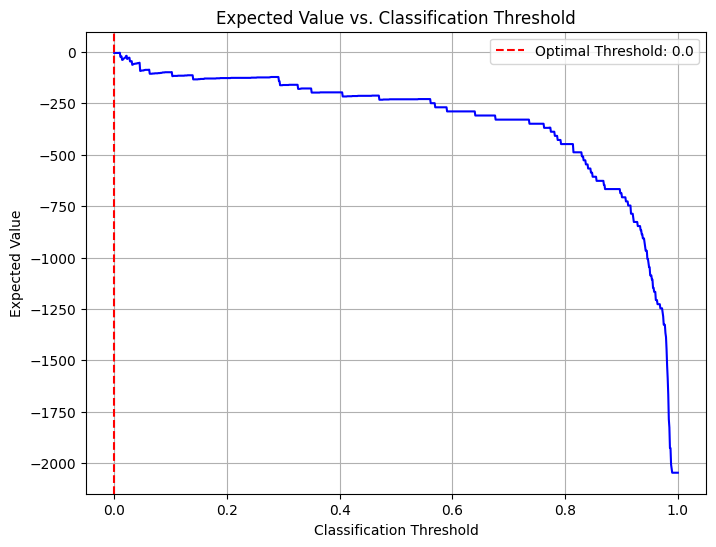

Optimal classification threshold: 0.0


In [18]:
# Define thresholds from 0 to 1 with ~1,000 steps
thresholds = np.linspace(0, 1, 1000)

# Get predicted probabilities for class 1 (delinquent)
y_probs = gb_clf_weighted.predict_proba(X_test)[:, 1]

# Initialize list to store expected values for each threshold
expected_values = []

# Iterate over each threshold
for t in thresholds:
    y_pred = (y_probs >= t).astype(int)  # Classify based on threshold
    tn, fp, fn, tp = confusion_matrix(
        y_test, y_pred
    ).ravel()  # Get confusion matrix values

    # Calculate expected value
    expected_value = (tn * 1) + (fp * -0.05) + (fn * -20) + (tp * 0)
    expected_values.append(expected_value)

# Find the threshold with the highest expected value
optimal_threshold = thresholds[np.argmax(expected_values)]

# Round to nearest 0.05
optimal_threshold = round(optimal_threshold * 20) / 20

# Store result
results["ex13_optimal_threshold"] = optimal_threshold

# Plot threshold vs. expected value
plt.figure(figsize=(8, 6))
plt.plot(thresholds, expected_values, marker="", linestyle="-", color="b")
plt.axvline(
    optimal_threshold,
    color="r",
    linestyle="--",
    label=f"Optimal Threshold: {optimal_threshold}",
)
plt.xlabel("Classification Threshold")
plt.ylabel("Expected Value")
plt.title("Expected Value vs. Classification Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Print the optimal threshold
print(f"Optimal classification threshold: {optimal_threshold}")

### Exercise 14

What is the value your customer will get at that (rounded-to-nearest-half-tenth) threshold per mortgage available (i.e., assume a True Negative yields a value of 1, calculate the value generated by your test data at your rounded optimal threshold, then normalize by the number of observations in the test data). Store this normalized value in `ex14_normalized_value`. **Round your answer to two decimal places.**

In [19]:
# Get predictions at the optimal threshold
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

# Compute confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_optimal).ravel()

# Compute total value
total_value = (tn * 1) + (fp * -0.05) + (fn * -20) + (tp * 0)

# Normalize by number of observations in the test set
normalized_value = total_value / len(y_test)

# Round to two decimal places
normalized_value = round(normalized_value, 2)

# Store result
results["ex14_normalized_value"] = normalized_value

# Print the normalized value
print(f"Normalized value per mortgage: {normalized_value}")

Normalized value per mortgage: -0.02


## Now To The Future

Most of the time, at least as students, we never get to see how well our predictions do. We fit our models on our training data, then evaluate their performance against our test data, and because we're evaluating our model against data it hadn't seen during training, we act as if we're really evaluating how well our predictions would fair if deployed in the real world.

But our mortgage data is from 2004, and as you may have noticed, 2004 was actually a while ago, which means we can now see how the model we trained on the first 24 months of payments on mortgages that originated in 2004 would do if we actually deployed it. To have our 24 months of payments, of course, the soonest we could have done the analysis above would have been in late 2006. So let's assume that your boss *immediately* deploys your model and starts buying up all the mortgages your model says should be purchased starting on January 1st 2007 and continued through December 31st 2007. 

Would you have gotten the average value per mortgage your model predicted? 



### Exercise 15

In this [folder](https://github.com/nickeubank/MIDS_Data/tree/master/mortgages/2007) you will find data on mortgages originated in 2007 along with servicing data from 2007, 2008, and 2009.

Please:

- load this data (again, from a URL to help the autograder). 
- clean up your data as you did the data from the earlier period, 
- use patsy to prepare the data so you can use the model **from above** (the model that used the reciprocal weights on data from mortgages originating in 2004) with this data. 

In other words, we're using the model you trained on 2004 data to predict credit risk for these new mortgages. We're doing this to simulate what you would do if you were to actually put the model you fit in Exercise 11 "into production" to model the risk of new mortgages. So you won't use the `.fit()` method again, just the `.predict()` method with the new data.


**Warning**: Because you are asking sklearn to use a model trained on one dataset to predict values using predictors from a second dataset, any difference in the structure of the second dataset will cause problems. For example, if `num_of_units` is an integer in the 2007 data when you try and run your predictions, but it was a float in the 2004 data, patsy will give the columns slightly different names and you'll get an error like this:

```python
ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- C(num_of_units)[T.2]
- C(num_of_units)[T.3]
- C(num_of_units)[T.4]
Feature names seen at fit time, yet now missing:
- C(num_of_units)[T.2.0]
- C(num_of_units)[T.3.0]
- C(num_of_units)[T.4.0]
```

This can be corrected by ensuring that `num_of_units` is of the same type when you run `dmatrices` for both datasets. 

Your final X matrix should still have 76 columns. As sanity checks, store the final number of observations in your data after using patsy to make a design matrix in `"ex15_num_obs"` and the share of mortgages in your design matrix that are actually delinquent in `"ex15_share_delinquent"`. **Round the share delinquent to three decimal places.**

**Hint:** The 2007 delinquency rate should be higher than the 2004 delinquency rate for reasons you can probably figure out if you google it. Something happened with mortgages between 2007 and 2009...

In [ ]:
from sklearn.pipeline import Pipeline

# Load 2007 data
orig_url = "https://github.com/nickeubank/MIDS_Data/raw/master/mortgages/2007/sample_orig_2007_standard_mortgages.txt.zip"
svcg_url = "https://github.com/nickeubank/MIDS_Data/raw/master/mortgages/2007/sample_svcg_2007_threeyears_standard_mortgages.txt.zip"

orig_data = pd.read_csv(
    orig_url, compression="zip", sep="|", header=None, low_memory=False
)
svcg_data = pd.read_csv(
    svcg_url, compression="zip", sep="|", header=None, low_memory=False
)

# Set column names
orig_columns = [
    "credit_score",
    "first_payment_date",
    "first_time_homebuyer_flag",
    "maturity_date",
    "msa",
    "mi_pct",
    "number_of_units",
    "occupancy_status",
    "cltv",
    "dti",
    "original_upb",
    "ltv",
    "interest_rate",
    "channel",
    "ppm_flag",
    "amortization_type",
    "property_state",
    "property_type",
    "postal_code",
    "loan_sequence_number",
    "loan_purpose",
    "original_loan_term",
    "number_of_borrowers",
    "seller_name",
    "servicer_name",
    "super_conforming_flag",
    "pre_relief_sn",
    "pro_indicator",
    "relief_re_indicator",
    "property_valuation_method",
    "interest_only_indicator",
    "mi_cancel_indicator",
]
orig_data.columns = orig_columns

svcg_columns = [
    "loan_sequence_number",
    "monthly_reporting_period",
    "current_upb",
    "current_loan_delinquency_status",
    "loan_age",
    "remaining_months_to_legal_maturity",
    "repurchase_flag",
    "modification_flag",
    "zero_balance_code",
    "zero_balance_effective_date",
    "current_interest_rate",
    "current_deferred_upb",
    "ddlpi",
    "mi_recoveries",
    "net_sale_proceeds",
    "non_mi_recoveries",
    "expenses",
    "legal_costs",
    "maintenance_and_preservation_costs",
    "taxes_and_insurance",
    "miscellaneous_expenses",
    "actual_loss_calculation",
    "modification_cost",
    "step_modification_flag",
    "deferred_payment_plan",
    "estimated_loan_to_value",
    "zero_balance_removal_upb",
    "delinquent_accrued_interest",
    "delinquency_due_to_disaster",
    "borrower_assistance_status",
    "current_month_modi_cost",
    "interest_bearing_upb",
]
svcg_data.columns = svcg_columns

# Merge origination and performance data
merged_data = pd.merge(orig_data, svcg_data, on="loan_sequence_number", how="inner")

# Create delinquency indicator
merged_data["delinquent"] = merged_data["current_loan_delinquency_status"].apply(
    lambda x: 1 if isinstance(x, str) and x.isdigit() and int(x) >= 1 else 0
)

# Group by loan and check if any delinquency occurred within first 24 months
y = (
    merged_data.groupby("loan_sequence_number")
    .apply(lambda x: (x["delinquent"].sum() > 0) & (x["loan_age"].max() <= 24))
    .astype(int)
)

# Select features for X
features = [
    "credit_score",
    "first_time_homebuyer_flag",
    "number_of_units",
    "occupancy_status",
    "cltv",
    "dti",
    "original_upb",
    "ltv",
    "interest_rate",
    "channel",
    "ppm_flag",
    "amortization_type",
    "property_state",
    "property_type",
    "original_loan_term",
    "number_of_borrowers",
    "mi_pct",
    "loan_sequence_number",
]

X = orig_data[orig_data["loan_sequence_number"].isin(y.index)][features]

# Ensure X and y have the same index
X = X.set_index("loan_sequence_number")
y = y.reindex(X.index)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define categorical and numeric features
categorical_features = [
    "first_time_homebuyer_flag",
    "occupancy_status",
    "channel",
    "ppm_flag",
    "amortization_type",
    "property_state",
    "property_type",
]
numeric_features = [
    "credit_score",
    "number_of_units",
    "cltv",
    "dti",
    "original_upb",
    "ltv",
    "interest_rate",
    "original_loan_term",
    "number_of_borrowers",
    "mi_pct",
]

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# Create a pipeline with the preprocessor and the classifier
pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", GradientBoostingClassifier(random_state=42)),
    ]
)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate results
num_obs = len(X)
share_delinquent = y.mean()

# Store results
results = {"ex15_num_obs": num_obs, "ex15_share_delinquent": round(share_delinquent, 3)}

print(f"Number of observations: {results['ex15_num_obs']}")
print(f"Share of delinquent mortgages: {results['ex15_share_delinquent']:.3f}")

C:\Users\xiaoz\AppData\Local\Temp\ipykernel_29204\1843789664.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y = merged_data.groupby("loan_sequence_number").apply(


Number of observations: 22542
Share of delinquent mortgages: 0.111


### Exercise 16




Had your stakeholder purchased all the mortgages originating in 2007 using your model trained on 2004 mortgages, what would the average normalized value of those mortgages be?

Store your result under the key `"ex16_normalized_value_2007"`. **Round your answer to 2 decimal places.**

Calculate the actual return your model provided as a percentage of the predicted return (e.g., `100 * results["ex16_normalized_value_2007"] / results["ex14_normalized_value"]`, so 1 is one percent, 100 is 100 percent). 

To be clear, you should do this calculation with the *rounded* values you stored in `results` (again, for the autograder — in general you should never round until the end of calculations, but we're trying to smooth little differences).

Store this result as `"ex16_final_return_pct"`. **Round this calculated percentage one decimal place.**



### Exercise 17

How did the performance of your model against your test data (from 2004) compare to your model's actual performance in later years (the 2007 data)? What lesson from our class readings does this illustrate, and how does it relate to internal and external validity?

The question is worth several points, and is meant to be the place where you reflect on why I made you do all this. Your answer should not be a couple sentences.